In [31]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [32]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='./dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

cuda:0


In [33]:
class Block(torch.nn.Module):
    def __init__(self,channels) -> None:
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=channels,out_channels=channels,kernel_size=3,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=channels,out_channels=channels,kernel_size=3,padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(y + x)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5)
        self.block1 = Block(16)
        self.block2 = Block(32)
        self.maxpool = torch.nn.MaxPool2d(2) 
        self.linear = torch.nn.Linear(512, 10)
 
    def forward(self, x):
        batch_size = x.size(0)
        x = self.maxpool(self.conv1(x)) # 16*12*12
        x = self.block1(x)
        x = self.maxpool(self.conv2(x)) # 32*4*4
        x = self.block2(x)
        x = x.view(batch_size,-1)
        x = self.linear(x)
        return x

In [34]:
model = Net()
model.to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [35]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        # 获得一个批次的数据和标签
        inputs, target = data
        inputs, target = inputs.to(device=device), target.to(device=device)
        optimizer.zero_grad()
        # 获得模型预测结果(64, 10)
        outputs = model(inputs)
        # 交叉熵代价函数outputs(64,10),target（64）
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device=device), labels.to(device=device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1) # dim = 1 列是第0个维度，行是第1个维度
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # 张量之间的比较运算
    return correct/total

[1,   300] loss: 0.471
[1,   600] loss: 0.155
[1,   900] loss: 0.109
train_accuracy (97,97) epoch:0
[2,   300] loss: 0.083
[2,   600] loss: 0.076
[2,   900] loss: 0.075
train_accuracy (98,98) epoch:1
[3,   300] loss: 0.060
[3,   600] loss: 0.053
[3,   900] loss: 0.057
train_accuracy (98,98) epoch:2
[4,   300] loss: 0.048
[4,   600] loss: 0.045
[4,   900] loss: 0.046
train_accuracy (98,98) epoch:3
[5,   300] loss: 0.039
[5,   600] loss: 0.038
[5,   900] loss: 0.038
[6,   300] loss: 0.032
[6,   600] loss: 0.036
[6,   900] loss: 0.033
train_accuracy (98,98) epoch:5
[7,   300] loss: 0.031
[7,   600] loss: 0.027
[7,   900] loss: 0.029
[8,   300] loss: 0.022
[8,   600] loss: 0.026
[8,   900] loss: 0.030
train_accuracy (98,98) epoch:7
[9,   300] loss: 0.023
[9,   600] loss: 0.023
[9,   900] loss: 0.023
train_accuracy (99,99) epoch:8
[10,   300] loss: 0.018
[10,   600] loss: 0.022
[10,   900] loss: 0.021
train_accuracy (99,99) epoch:9
accuracy (99,99)


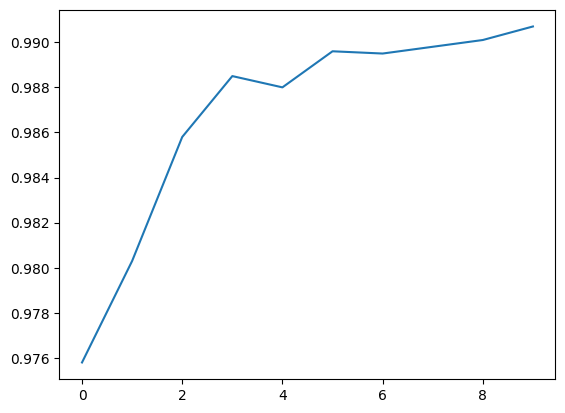

In [36]:
if __name__ == '__main__':
    accuracy_max = 0
    accuracy = 0
    accuracys = []
    for epoch in range(10):
        train(epoch)
        accuracy = test()
        if(accuracy_max < accuracy):
            accuracy_max = accuracy
            print("save: train_accuracy (%d,%d) epoch:%d"%(accuracy* 100,accuracy_max * 100,epoch))
            torch.save(model.state_dict(), "./save/py9.pt")
        accuracys.append(accuracy)
    print("accuracy (%d,%d)"%(accuracy* 100,accuracy_max * 100))
    plt.plot(accuracys)